In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

frame_level
label_names.csv
label_names.csv.zip
sample_submission.csv
sample_submission.csv.zip
train_labels.csv
validate_labels.csv
video_level
vocabulary.csv



In [2]:
import tensorflow as tf
import numpy as np

frame_lvl_record = "../../input/frame_level/train-1.tfrecord"

In [3]:
# now, let's read the frame-level data
# due to execution time, we're only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break

In [4]:
feat_rgb = np.asarray(feat_rgb).squeeze()
feat_rgb_shape = np.shape(feat_rgb)

print('The first video has %d frames' %feat_rgb_shape[0])
print('and contains %d features.' %feat_rgb_shape[1])
print('The features are of data type %s.' %np.dtype(feat_rgb[0,0]))


The first video has 180 frames
and contains 1024 features.
The features are of data type float32.


In [5]:
from scipy.linalg import svd

# Perform SVD
[U, Sv, Vh] = svd(feat_rgb.astype(np.float64), full_matrices=False,
                          overwrite_a=False, check_finite=False)

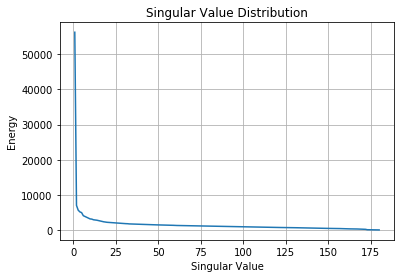

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Plot Singular Values
x = np.arange(1,len(Sv)+1)
plt.plot(x,Sv)
plt.xlabel('Singular Value')
plt.ylabel('Energy')
plt.title('Singular Value Distribution')
plt.grid(True)
plt.show()

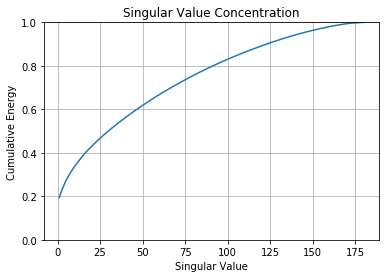

In [7]:
# Plot Cumulative Singular Values
Sv_cum = np.cumsum(Sv)/np.sum(Sv)
plt.plot(x,Sv_cum)
plt.ylim(0,1)
plt.xlabel('Singular Value')
plt.ylabel('Cumulative Energy')
plt.title('Singular Value Concentration')
plt.grid(True)
plt.show()

In [8]:
from __future__ import division
Sv_perc50 = np.size(np.where(Sv_cum < 0.5)[0])
print('~50%% of the cumulative SV is contained in the first %d SVs, '
      'equivalent to ~%d%% of all SVs' %(Sv_perc50, 100*Sv_perc50/len(Sv)))

~50% of the cumulative SV is contained in the first 29 SVs, equivalent to ~16% of all SVs


In [9]:
# Benchmark different SVD methods

import time
from sklearn.utils.extmath import randomized_svd
# import sklearn.decomposition.TruncatedSVD

# Number of components for truncated SVD
nComps = 16

ts = []
t = time.time()
[U, Sv, Vh] = svd(feat_rgb, full_matrices=False, check_finite=False)
ts.append(time.time() - t)

t = time.time()
[U, Sv, Vh] = randomized_svd(feat_rgb, n_components=nComps)
ts.append(time.time() - t)

a = tf.constant(feat_rgb)
tf.InteractiveSession()
t = time.time()
s, u, v = tf.svd(a)
ts.append(time.time() - t)

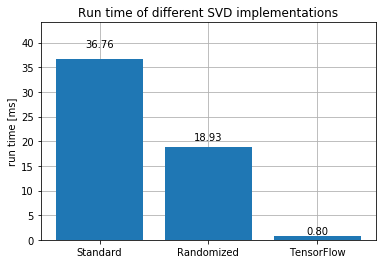

In [10]:
# Visualized ts

ax = plt.subplot(111)
rects = ax.bar(np.arange(3),np.asarray(ts)*1000, zorder=3)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('Standard','Randomized','TensorFlow'))
ax.set_ylabel('run time [ms]')
ax.set_title('Run time of different SVD implementations')
i = 0
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%.2f' % (ts[i]*1000),
            ha='center', va='bottom')
    i = i+1
ax.set_ylim([0,1000*1.2*np.asarray(ts).max()])
ax.grid(zorder=0)
plt.show()